In [1]:

import numpy as np
import sys
sys.path.append("..")
from config import *
import time
import os
from tqdm import tqdm
import nibabel as nib
import scipy.ndimage as snd
from widgets import *
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from widgets import ContrastsViewer3D

from analysis import load_results, compute_lw_model_results, compute_pw_model_results, compute_curves, compare_pw_models, compare_lw_models, print_confusion_matrix, get_votes_lw, compute_metrics
from utils import get_folds_structure

Loading configuration...
Configuration loaded successfully!
_____________________________



In [2]:

FPR = 0.05
CHRONIC_TH = 4

## Loading data

In [3]:
%%time
lw_results = load_results()

"""
mprage_p2 = [int(pat) for arr in get_folds_structure("mprage_p2") for (d, pat) in arr]
lw_results = lw_results.reset_index()
lw_results = lw_results.drop(lw_results[(lw_results["model_name"] == "sk_mono_mp2uni_basel_P2") & (~lw_results["patient"].isin(mprage_p2))].index)
lw_results = lw_results.drop(lw_results[(lw_results["model_name"] == "sk_mono_mp2uni_mprage_basel_P2") & (~lw_results["patient"].isin(mprage_p2))].index)
lw_results = lw_results.drop(lw_results[(lw_results["model_name"] == "sk_mono_mp2uni_basel_P1") & (lw_results["patient"].isin(mprage_p2))].index)
lw_results = lw_results.drop(lw_results[(lw_results["model_name"] == "sk_mono_mp2uni_mprage_basel_P1") & (lw_results["patient"].isin(mprage_p2))].index)
"""

lw_th_results, lw_th_per_fold, lw_th_per_model = compute_lw_model_results(lw_results, FPR)
pw_results, pw_per_fold, pw_per_model = compute_pw_model_results(lw_results, FPR, CHRONIC_TH)

83 models available.


/home/german/msrims/testing/analysis.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_by_fold["pred_th"] = 0
/home/german/miniconda3/envs/msrims2/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/german/msrims/testing/analysis.py:68: RuntimeWarning: invalid value encountered in double_scalars
  f1 = 2 * (ppv * tpr) / (ppv + tpr)
/home/german/msrims/testing/analysis.py:65: RuntimeWarning: invalid value encountered in lo

CPU times: user 27.7 s, sys: 178 ms, total: 27.9 s
Wall time: 29 s


## Statistical comparison - McNemar

In [12]:

m0 = ("binet_phase_flair", "all", False)
m1 = ("Pietro", "all", False)

#compare_lw_models(lw_th_results, m0,  m1)
compare_pw_models(lw_th_results, pw_results, m0,  m1, CHRONIC_TH)


[[61 22]
 [33  8]]
statistic=22.00000, p-value=0.17700
Same proportions of errors (fail to reject H0)


In [6]:

m1 = ("Martina", "all", False)
compare_pw_models(lw_th_results, pw_results, m0,  m1, CHRONIC_TH)

[[60 23]
 [35  6]]
statistic=23.00000, p-value=0.14801
Same proportions of errors (fail to reject H0)


In [7]:
name = "binet_phase_flair"
fv = "chuv"
ensembled = False
lw_th_per_model[(lw_th_per_model["evaluation"] == fv) & (lw_th_per_model["model_name"] == name) & (lw_th_per_model["ensembled"] == ensembled)]

,model_name,evaluation,ensembled,auc,tn,fp,fn,tp,acc,f1,tpr,fpr,ppv,npv
4,binet_phase_flair,chuv,False,0.958232,1947,101,36,113,0.937662,0.619327,0.76,0.049313,0.524112,0.981927


In [8]:
model_1 = ("binet_phase_flair", "all", False)

votes = get_votes_lw(lw_th_results, "all")
m1 = lw_th_results.loc[(lw_th_results["unseen"] == 1) & (lw_th_results["model_name"] == model_1[0]) & (lw_th_results["evaluation"] == model_1[1]) & (lw_th_results["ensembled"] == model_1[2])]
prova = pd.merge(m1, votes, on=["dataset", "patient", "lesion"], how="inner")
prova["Martina*"] = prova.apply(lambda row: (row["Martina"] == 1) or ((row["pred"] == 1) and (row["truth_x"] == 1)), axis = 1)
prova["Pietro*"] = prova.apply(lambda row: (row["Pietro"] == 1) or ((row["pred"] == 1) and (row["truth_x"] == 1)), axis = 1)

print("> Martina")
print(compute_metrics(prova["truth_x"], prova["Martina"]))
print(compute_metrics(prova["truth_x"], prova["Martina*"]))

print("> Pietro")
print(compute_metrics(prova["truth_x"], prova["Pietro"]))
print(compute_metrics(prova["truth_x"], prova["Pietro*"]))

> Martina
(4844, 13, 104, 358, 0.9780033840947546, 0.8595438175270108, 0.7748917748917749, 0.0026765493102738317, 0.9649595687331537, 0.978981406628941)
(4844, 13, 40, 422, 0.990035721000188, 0.9409141583054627, 0.9134199134199135, 0.0026765493102738317, 0.9701149425287356, 0.9918099918099919)
> Pietro
(4846, 11, 102, 360, 0.9787554051513442, 0.8643457382953181, 0.7792207792207793, 0.0022647724933086266, 0.9703504043126685, 0.9793856103476152)
(4846, 11, 45, 417, 0.9894717052077459, 0.9370786516853933, 0.9025974025974026, 0.0022647724933086266, 0.9742990654205608, 0.9907994275199346)


## ROC and PR curves

Series([], Name: model_name, dtype: object)


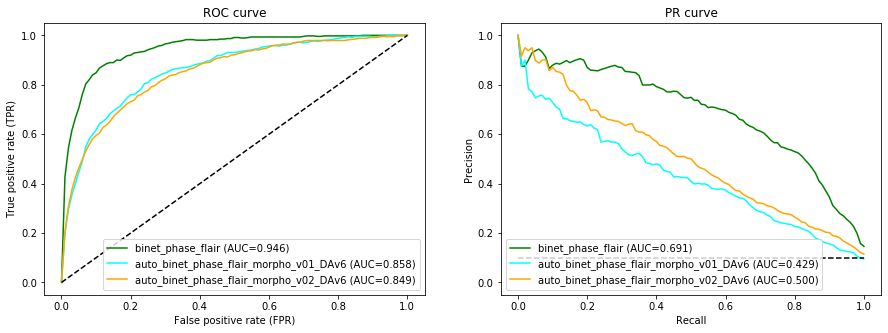

In [65]:

TO_TEST = ("all", (
    ("monomodal_flair", "all", False, "lightcoral", ":" ),
    ("monomodal_t2star", "all", False, "green", ":" ),
    ("monomodal_phase", "all", False, "darkblue", ":" ),
    ("binet_t2star_flair", "all", False, "palegreen", "-" ),
    ("binet_phase_t2star", "all", False, "navy", "-" ),
    ("binet_phase_flair", "all", False, "lightcoral", "-" ),
))
TO_TEST = ("chuvPT", (
    #("binet_t2star_flair", "chuv", False, "palegreen", ":" ),
    #("binet_phase_t2star", "chuv", False, "navy", ":" ),
    ("binet_phase_flair", "chuv", False, "lightcoral", ":" ),
    #("binet_t2star_flair_basel", "chuv", True, "palegreen", "-" ),
    #("binet_phase_t2star_basel", "chuv", True, "navy", "-" ),
    ("binet_phase_flair_basel", "chuv", True, "lightcoral", "-" ),
))
TO_TEST = ("onlybasel_all", (
    ("mono_flair_basel", "basel", False, "lightcoral", ":" ),
    ("mono_t2star_basel", "basel", False, "green", ":" ),
    ("mono_phase_basel", "basel", False, "darkblue", ":" ),
    ("binet_phase_flair_basel", "basel", False, "lightcoral", "-" ),
    ("binet_phase_mp2uni_basel", "basel", False, "gold", "-" ),
    #("rimnet_ph_mp2u_fl_basel", "basel", False, "red", "-" ),
    ("rimnet_v2_ph_mp2u_fl_basel", "basel", False, "red", "-" ),
))
     
TO_TEST = ("2vs3rimnet", (
    ("binet_t2star_flair", "all", False, "palegreen", "-" ),
    ("binet_phase_t2star", "all", False, "navy", "-" ),
    ("binet_phase_flair", "all", False, "lightcoral", "-" ),
    ("rimnet_flair", "all", False, "red", "-" ),
))
     
TO_TEST = ("FLAIRvsSTARrimnet", (
    ("rimnet_flair", "all", False, "red", "-" ),
    ("rimnet_flairstar", "all", False, "navy", "-" ),
    ("rimnet_eflair_bl", "all", False, "palegreen", "-" ),
))
TO_TEST = ("onlybasel_mp2map", (
    #("mono_flair_basel", "basel", False, "gray", ":" ),
    #("mono_t2star_basel", "basel", False, "green", ":" ),
    ("mono_mp2uni_basel", "basel", False, "red", ":" ),
    ("mono_mp2map_basel", "basel", False, "black", "-" ),
    ("mono_phase_basel", "basel", False, "darkblue", ":" ),
    ("binet_phase_flair_basel", "basel", False, "lightcoral", "-" ),
    ("binet_phase_mp2map_basel", "basel", False, "red", "-" ),
    ("binet_phase_mp2uni_basel", "basel", False, "gold", "-" ),
    #("rimnet_ph_mp2u_fl_basel", "basel", False, "red", "-" ),
    ("rimnet_v2_ph_mp2u_fl_basel", "basel", False, "red", "-" ),
))

    
TO_TEST = ("onlybasel_all", (
    ("mono_flair_basel", "basel", False, "lightcoral", ":" ),
    ("mono_t2star_basel", "basel", False, "green", ":" ),
    ("mono_mp2uni_basel", "basel", False, "cyan", ":" ),
    ("mono_phase_basel", "basel", False, "darkblue", ":" ),
    ("binet_phase_flair_basel", "basel", False, "lightcoral", "-" ),
    ("binet_phase_mp2uni_basel", "basel", False, "gold", "-" ),
    #("rimnet_ph_mp2u_fl_basel", "basel", False, "red", "-" ),
    #("rimnet_v2_ph_mp2u_fl_basel", "basel", False, "red", "-" ),
))
TO_TEST = ("skull_stripped", (
    #("sk_mono_phase_basel", "chuv", True, "black", "-" ),
    #("sk_mono_mp2uni_basel", "chuv", True, "green", "-" ),
    #("sk_mono_mp2uni_mprage_basel", "chuv", True, "green", ":" ),
    ("binet_phase_flair_basel", "chuv", True, "black", "-" ),
    ("sk_binet_phase_mp2uni_basel", "chuv", True, "red", "-" ),
    ("sk_binet_phase_mp2uni_mprage_basel", "chuv", True, "red", ":" ),
))
TO_TEST = ("by_mprage_protocol", (
    ("sk_mono_mp2uni_mprage_basel_P1", "chuv", True, "red", ":" ),
    ("sk_mono_mp2uni_mprage_basel_P2", "chuv", True, "blue", ":" ),
    ("sk_mono_mp2uni_mprage_basel", "chuv", True, "red", "-" ),
))
TO_TEST = ("by_mprage_protocol_mono", (
    ("sk_mono_mp2uni_basel_P1", "chuv", True, "red", ":" ),
    ("sk_mono_mp2uni_basel_P2", "chuv", True, "blue", ":" ),
    ("sk_mono_mp2uni_basel", "chuv", True, "red", "-" ),
))
TO_TEST = ("by_mprage_protocol_P1", (
    ("sk_mono_mp2uni_basel_P1", "chuv", True, "blue", ":" ),
    ("sk_mono_mp2uni_mprage_basel_P1", "chuv", True, "red", ":" ),
    ("sk_mono_mp2uni_basel", "chuv", True, "red", "-" ),
))
TO_TEST = ("onlybasel_mprage_mono", (
    ("mono_flair_basel", "basel", False, "lightcoral", ":" ),
    ("mono_t2star_basel", "basel", False, "green", ":" ),
    ("mono_mp2uni_basel", "basel", False, "orange", "-" ),
    ("mono_mp2map_basel", "basel", False, "blue", "-" ),
    ("mono_phase_basel", "basel", False, "black", ":" ),
))
TO_TEST = ("onlybasel_mprage_binet", (
    ("binet_phase_flair_basel", "basel", False, "black", ":" ),
    ("binet_phase_mp2uni_basel", "basel", False, "orange", "-" ),
    ("binet_phase_mp2map_basel", "basel", False, "blue", "-" ),
))
TO_TEST = ("auto_pipeline_results", (
    ("auto_binet_phase_flair", "pilot_testing", False, "darkblue", "-" ),
    ("auto_mono_phase", "pilot_testing", False, "darkorange", "-" ),
))
TO_TEST = ("nih_mp2rage_mapVSuni_mono", (
    ("mono_mp2uni_basel", "nih7T_testing", True, "orange", "-" ),
    ("mono_mp2uni_basel", "basel", False, "orange", ":" ),
    ("mono_mp2map_basel_interp", "nih7T_testing", True, "green", "-" ),
    ("mono_mp2map_basel_interp", "basel", False, "green", ":" ),
    #("mono_mp2map_basel", "nih7T_testing", True, "black", "-" ),
    #("mono_mp2map_basel", "basel", False, "black", "-" ),
))

TO_TEST = ("inter_hospital_study_chuv", (
    ("binet_phase_flair", "basel", False, "darkblue", ":" ),
    #("binet_phase_flair_basel", "chuv", False, "lightcoral", "-" ),
    #("binet_phase_flair_basel", "chuv", True, "darkred", "-" ),
    #("binet_phase_flair_chuv", "basel", False, "skyblue", "-" ),
    ("binet_phase_flair_chuv", "basel", True, "darkblue", "-" ),
))
TO_TEST = ("7T_VS_3T", (
    ("mono_mp2uni_basel", "nih7T_testing_morpho_v01_3T", True, "blue", ":" ),
    ("mono_mp2uni_basel", "nih7T_testing_morpho_v01_7T", True, "blue", "-" ),
    ("mono_mp2map_basel_interp", "nih7T_testing_morpho_v01_7T", True, "orange", "-" ),
))

TO_TEST = ("autosplit", (
    ("binet_phase_flair", "all", False, "green", "-" ),
    #("binet_phase_flair", "all_auto_pmap_v05", False, "orange", "-" ),
    #("binet_phase_flair", "all_morpho_v01", False, "red", "-" ),
    #("binet_phase_flair", "all_morpho_v02", False, "blue", "-" ),
    ("auto_binet_phase_flair_morpho_v01_DAv6", "all_morpho_v01", False, "cyan", "-" ),
    ("auto_binet_phase_flair_morpho_v02_DAv6", "all_morpho_v02_maxDA", False, "orange", "-" ),
))


try:
    compute_curves(lw_results, TO_TEST[0], TO_TEST[1])
except Exception as ex:
    print("ERRORs")
    print(ex.args)
    
print(lw_th_per_model.loc[lw_th_per_model["model_name"].str.contains("rimnet"), "model_name"])

## Confusion matrices

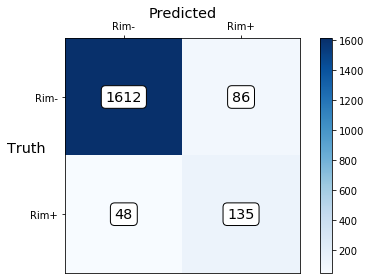

<Figure size 432x288 with 0 Axes>

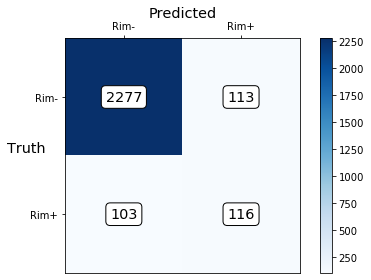

<Figure size 432x288 with 0 Axes>

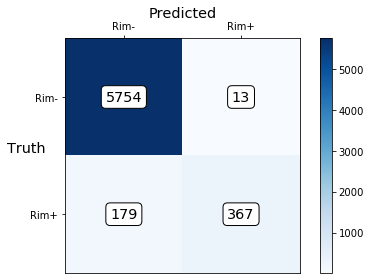

<Figure size 432x288 with 0 Axes>

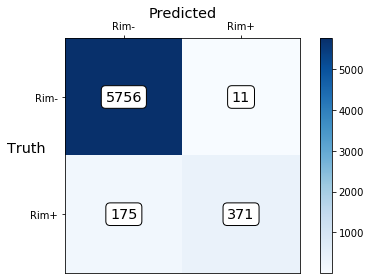

<Figure size 432x288 with 0 Axes>

In [112]:
print_confusion_matrix(lw_th_per_model, ("binet_phase_flair", "all_auto", False), "LW", FPR)
print_confusion_matrix(lw_th_per_model, ("binet_phase_flair_AUTO", "all_auto", False), "LW", FPR)
print_confusion_matrix(lw_th_per_model, ("Martina", "all", True), "LW", FPR)
print_confusion_matrix(lw_th_per_model, ("Pietro", "all", True), "LW", FPR)

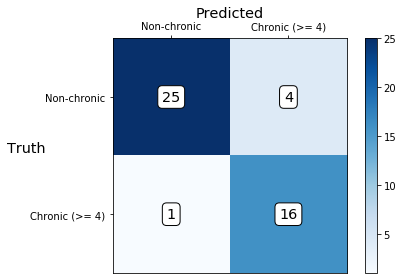

<Figure size 432x288 with 0 Axes>

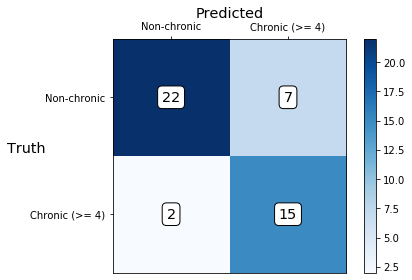

<Figure size 432x288 with 0 Axes>

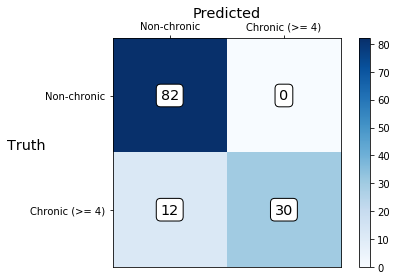

<Figure size 432x288 with 0 Axes>

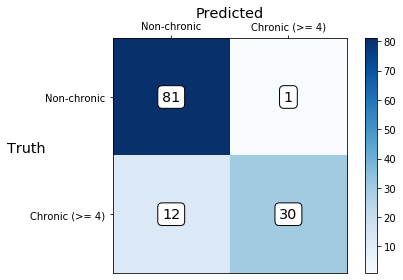

<Figure size 432x288 with 0 Axes>

In [115]:
print_confusion_matrix(pw_per_model, ("binet_phase_flair", "all_auto", False), "PW", FPR, chronicity_th=4)
print_confusion_matrix(pw_per_model, ("binet_phase_flair_AUTO", "all_auto", False), "PW", FPR, chronicity_th=CHRONIC_TH)
print_confusion_matrix(pw_per_model, ("Martina", "all", True), "PW", FPR, chronicity_th=CHRONIC_TH)
print_confusion_matrix(pw_per_model, ("Pietro", "all", True), "PW", FPR, chronicity_th=CHRONIC_TH)

# CONFLUENT LESIONS ANALYSIS

In [37]:
conf_df = pd.read_csv("/Users/german/Desktop/results_confluent.csv")
conf_df["confluent"] = True
lw_conf = pd.merge(lw_results, conf_df, on=["dataset", "patient", "lesion"], how="left")
lw_conf

,model_name,evaluation,ensembled,fold,database,patient,lesion,unseen,truth,pred,Unnamed: 0,confluences,rim_pos_confluent,confluent
0,bimodal_phase_flair,all,False,0,0,56,2000,0,0,0.021313,NaN,NaN,NaN,NaN
1,bimodal_phase_flair,all,False,1,0,56,2000,0,0,0.143120,NaN,NaN,NaN,NaN
2,bimodal_phase_flair,all,False,2,0,56,2000,0,0,0.005009,NaN,NaN,NaN,NaN
3,bimodal_phase_flair,all,False,3,0,56,2000,1,0,0.030391,NaN,NaN,NaN,NaN
4,bimodal_phase_flair,all,False,0,0,56,2001,0,0,0.922694,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453855,mono_t2star_basel,chuv,True,0,1,55,2014,1,0,0.444926,NaN,NaN,NaN,NaN
453856,mono_t2star_basel,chuv,True,0,1,55,2015,1,0,0.672084,NaN,NaN,NaN,NaN
453857,mono_t2star_basel,chuv,True,0,1,55,2016,1,0,0.446431,NaN,NaN,NaN,NaN
453858,mono_t2star_basel,chuv,True,0,1,55,2018,1,0,0.932096,NaN,NaN,NaN,NaN


In [42]:
conf_lw_th_results, _, conf_lw_th_per_model = compute_lw_model_results(lw_conf[lw_conf["confluent"] == True], FPR)
nconf_lw_th_results, _, nconf_lw_th_per_model = compute_lw_model_results(lw_conf[lw_conf["confluent"].isna()], FPR)

/Users/german/miniconda3/envs/msrims/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/german/miniconda3/envs/msrims/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


In [46]:
conf_lw_th_per_model[conf_lw_th_per_model["model_name"].str.contains("binet")].head()

,model_name,evaluation,ensembled,auc,tn,fp,fn,tp,acc,f1,tpr,fpr,ppv,npv
8,binet_phase_t2star,all,False,0.863559,256,12,168,87,0.658008,0.495685,0.349855,0.044994,0.877017,0.605795
3,binet_phase_flair,all,False,0.849740,256,12,182,73,0.622662,0.403641,0.275366,0.045942,0.833364,0.581098
12,binet_t2star_flair,all,False,0.832025,255,13,180,75,0.624118,0.417475,0.293163,0.047804,0.830952,0.587094
10,binet_phase_t2star_basel,basel,False,0.869326,152,7,93,69,0.686185,0.576644,0.423558,0.043846,0.907911,0.618564
7,binet_phase_mp2uni_basel,basel,False,0.829129,152,7,135,27,0.553249,0.318627,0.164452,0.042192,0.567391,0.533562


In [47]:
nconf_lw_th_per_model[nconf_lw_th_per_model["model_name"].str.contains("binet")].head()

,model_name,evaluation,ensembled,auc,tn,fp,fn,tp,acc,f1,tpr,fpr,ppv,npv
3,binet_phase_flair,all,False,0.928599,4359,232,74,135,0.936260,0.463642,0.642859,0.050520,0.364109,0.983307
8,binet_phase_t2star,all,False,0.927461,4373,218,67,142,0.940608,0.491455,0.672139,0.047504,0.388469,0.984920
12,binet_t2star_flair,all,False,0.906520,4372,219,92,117,0.935217,0.425187,0.562423,0.047697,0.345152,0.979410
7,binet_phase_mp2uni_basel,basel,False,0.919376,2520,131,69,84,0.928738,0.447156,0.541215,0.049352,0.382354,0.973342
5,binet_phase_flair_basel,basel,False,0.898742,2517,134,59,94,0.931132,0.479007,0.596747,0.050548,0.400093,0.977075


# EXTRACTION OF FP AND FN MASKS

In [12]:
FP_TH = 0.95
FN_TH = 0.05

In [13]:
from utils import read_patients_metadata
metadata = read_patients_metadata(PATCH_SIZE)

res = lw_results.loc[(lw_results["model_name"] == "binet_phase_flair") & (lw_results["evaluation"] == "all") & (lw_results["unseen"] == 1) & (lw_results["lesion"] // 1000 == 2)]
FPs = res.loc[res["pred"] >= FP_TH][["dataset", "patient", "lesion"]]
FPs["GT"] = "-"
FPs["RimNet"] = "+"
FPs["Result"] = "FP"

res = lw_results.loc[(lw_results["model_name"] == "binet_phase_flair") & (lw_results["evaluation"] == "all") & (lw_results["unseen"] == 1) & (lw_results["lesion"] // 1000 == 1)]
FNs = res.loc[res["pred"] <= FN_TH][["dataset", "patient", "lesion"]]
FNs["GT"] = "+"
FNs["RimNet"] = "-"
FNs["Result"] = "FN"

print("> FP: " + str(len(FPs.index)) + " lesions and " + str(len(FPs["patient"].drop_duplicates().index)) + " patients")
print("> FN: " + str(len(FNs.index)) + " lesions and " + str(len(FNs["patient"].drop_duplicates().index)) + " patients")
print("> Intersection: " + str(len([i for i in list(FNs["patient"].drop_duplicates()) if i in list(FPs["patient"].drop_duplicates())])) + " patients")
total_patients = pd.concat((FNs["patient"], FPs["patient"])).drop_duplicates()
print("> Total: " + str(len(total_patients.index)) + " patients")
print(sorted(total_patients))

> FP: 47 lesions and 23 patients
> FN: 36 lesions and 22 patients
> Intersection: 9 patients
> Total: 36 patients
[13, 14, 29, 39, 43, 46, 47, 48, 49, 51, 54, 64, 65, 70, 74, 75, 78, 84, 85, 92, 93, 94, 95, 101, 102, 108, 109, 113, 114, 115, 118, 124, 127, 129, 130, 132]


In [14]:
csv = pd.concat((FPs, FNs)).sort_values(["patient", "lesion"])
csv["Center"] = csv.apply(lambda row: metadata[row["dataset"]][row["patient"]][str(row["lesion"])]["center"], axis=1)
csv["Hospital"] = csv["dataset"].apply(lambda db: "Basel" if db == 0 else "CHUV")
csv["Mask_ID"] = csv["patient"].apply(lambda pat: f"sub-{pat:03d}")

correspondences = pd.read_csv("/Users/german/Desktop/RimProject/excels/all_participants.csv", sep=";")
correspondences["Mask_ID"] = correspondences["participant_id"]
correspondences["Hospital_ID"] = correspondences["center_id"]
correspondences = correspondences[["Mask_ID", "Hospital_ID"]]

csv = pd.merge(csv, correspondences, on="Mask_ID", how="left")

csv["Vote"] = ""
csv["Rim visibility (1-4)"] = ""
csv["Image quality (1-4)"] = ""
csv["Confluent"] = ""
csv["Comments"] = ""
csv["Lesion_ID"] = csv["lesion"]

csv = csv[["Hospital", "Hospital_ID", "Mask_ID", "Lesion_ID", "GT", "RimNet", "Result", "Center", "Vote", "Rim visibility (1-4)", "Image quality (1-4)", "Confluent", "Comments"]]
csv

,Hospital,Hospital_ID,Mask_ID,Lesion_ID,GT,RimNet,Result,Center,Vote,Rim visibility (1-4),Image quality (1-4),Confluent,Comments
0,CHUV,33,sub-013,2022,-,+,FP,"[93, 225, 286]",,,,,
1,CHUV,34,sub-014,1000,+,-,FN,"[81, 128, 235]",,,,,
2,CHUV,73,sub-029,1000,+,-,FN,"[65, 216, 201]",,,,,
3,CHUV,73,sub-029,1007,+,-,FN,"[93, 190, 285]",,,,,
4,CHUV,104,sub-039,1004,+,-,FN,"[41, 250, 212]",,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Basel,INSIDER_P084,sub-129,2023,-,+,FP,"[90, 224, 267]",,,,,
79,Basel,INSIDER_P085,sub-130,1001,+,-,FN,"[183, 221, 211]",,,,,
80,Basel,INSIDER_P085,sub-130,1009,+,-,FN,"[72, 206, 268]",,,,,
81,Basel,INSIDER_P091,sub-132,1001,+,-,FN,"[102, 128, 279]",,,,,


In [15]:
#csv.to_csv("/Users/german/Desktop/second_rating.csv", index=False)

In [16]:

def save_mask(dataset, patient, lesions):
    #print(lesions)
    dataset = AVAILABLE_DATASETS[dataset]
    mask_fn = dataset.get(return_type="filename", subject=f"{patient:03d}", **MASK)[0]
    mask_im = nib.load(mask_fn)
    mask = mask_im.get_fdata().astype(int)
    mask_result = np.zeros_like(mask).astype(float)
    for les in lesions:
        mask_result[mask == les] =  float(les)
        
    lesions_folder = os.path.join("/Users/german/Desktop/second_rating/masks")
    # we create folder if it does not exist
    if not os.path.exists(lesions_folder):
        os.makedirs(lesions_folder)
        
    # REAL CENTER ID
    center_id = correspondences.loc[correspondences["Mask_ID"] == f"sub-{patient:03d}", "Hospital_ID"].values[0]
    print(center_id)
    
    result_img = nib.Nifti1Image(mask_result, mask_im.affine)
    result_img.to_filename(os.path.join(lesions_folder, f"{center_id}.nii.gz"))
    
def save_all():
    for (hospital, pat), grouped in tqdm(csv.groupby(["Hospital", "Mask_ID"])):
        pat = int(pat.split("-")[1])
        db = 0
        if hospital == "CHUV":
            db = 1
        lesions = list(grouped["Lesion_ID"])
        save_mask(db, pat, lesions)
        
#save_all()

In [36]:
"""
for root, subdirs, files in os.walk("/Users/german/Downloads/T1maps"):
    for subdir in subdirs:
        equiv = correspondences.loc[correspondences["Hospital_ID"].str.lower() == subdir.lower(), "Mask_ID"].values[0]
        equiv = str(int(equiv.split("-")[1]))
        print(equiv)
        os.rename(os.path.join(root, subdir), os.path.join(root, equiv))
"""

'\nfor root, subdirs, files in os.walk("/Users/german/Downloads/T1maps"):\n    for subdir in subdirs:\n        equiv = correspondences.loc[correspondences["Hospital_ID"].str.lower() == subdir.lower(), "Mask_ID"].values[0]\n        equiv = str(int(equiv.split("-")[1]))\n        print(equiv)\n        os.rename(os.path.join(root, subdir), os.path.join(root, equiv))\n'

Text(0.5, 1.0, 'Distribution of MP2RAGE T1map predictions')

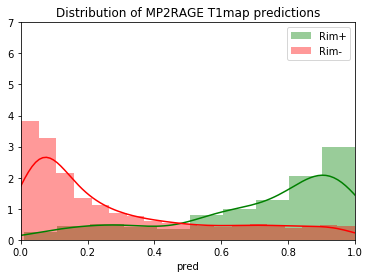

In [125]:
NAME = "mono_mp2map_basel_interp"

to_analize_pos = lw_results[(lw_results["lesion"] // 1000 == 1) & (lw_results["model_name"] == NAME) & (lw_results["evaluation"] == "basel") & (~lw_results["ensembled"]) & (lw_results["unseen"])]
to_analize_neg = lw_results[(lw_results["lesion"] // 2000 == 1) & (lw_results["model_name"] == NAME) & (lw_results["evaluation"] == "basel") & (~lw_results["ensembled"]) & (lw_results["unseen"])]
th = lw_th_per_fold.loc[(lw_th_per_fold["model_name"] == NAME) & (lw_th_per_fold["evaluation"] == "basel"), "th"].mean()

#to_analize_pos["pred_class"] = to_analize.apply(lambda row: int(row["pred"] >= th), axis=1)

plt.figure(figsize=(6, 4))
sns.distplot(to_analize_pos["pred"], label="Rim+", color="green")
sns.distplot(to_analize_neg["pred"], label="Rim-", color="red")
plt.xlim((0,1))
plt.ylim((0,7))
plt.legend()
plt.title("Distribution of MP2RAGE T1map predictions")
#plt.savefig("mp2map.png", dpi=250)



0.8985279351472855


Text(0.5, 1.0, 'Distribution of MP2RAGE UNI predictions')

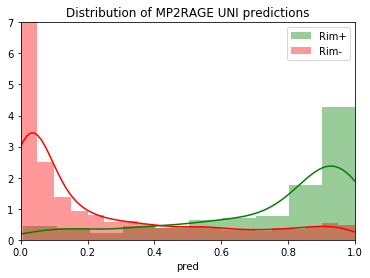

In [126]:

NAME = "mono_mp2uni_basel"

to_analize_pos = lw_results[(lw_results["lesion"] // 1000 == 1) & (lw_results["model_name"] == NAME) & (lw_results["evaluation"] == "basel") & (~lw_results["ensembled"]) & (lw_results["unseen"])]
to_analize_neg = lw_results[(lw_results["lesion"] // 2000 == 1) & (lw_results["model_name"] == NAME) & (lw_results["evaluation"] == "basel") & (~lw_results["ensembled"]) & (lw_results["unseen"])]
th = lw_th_per_fold.loc[(lw_th_per_fold["model_name"] == NAME) & (lw_th_per_fold["evaluation"] == "basel"), "th"].mean()

to_analize["pred_class"] = to_analize.apply(lambda row: int(row["pred"] >= th), axis=1)
print(th)
to_analize


plt.figure(figsize=(6, 4))
sns.distplot(to_analize_pos["pred"], label="Rim+", color="green")
sns.distplot(to_analize_neg["pred"], label="Rim-", color="red")
plt.xlim((0,1))
plt.ylim((0,7))
plt.legend()
plt.title("Distribution of MP2RAGE UNI predictions")
#plt.savefig("mp2uni.png", dpi=250)

# Volume analysis

In [5]:
from utils import get_dataframe_from_metadata

In [7]:
df = get_dataframe_from_metadata()
df

[WARNING] Subject 1 was omitted because no lesions 'json' file was found.
[WARNING] Subject 2 was omitted because no lesions 'json' file was found.
[WARNING] Subject 3 was omitted because no lesions 'json' file was found.
[WARNING] Subject 4 was omitted because no lesions 'json' file was found.
[WARNING] Subject 5 was omitted because no lesions 'json' file was found.
[WARNING] Subject 6 was omitted because no lesions 'json' file was found.
[WARNING] Subject 7 was omitted because no lesions 'json' file was found.
[WARNING] Subject 8 was omitted because no lesions 'json' file was found.
[WARNING] Subject 9 was omitted because no lesions 'json' file was found.
[WARNING] Subject 10 was omitted because no lesions 'json' file was found.
[WARNING] Subject 11 was omitted because no lesions 'json' file was found.
[WARNING] Subject 12 was omitted because no lesions 'json' file was found.
[WARNING] Subject 13 was omitted because no lesions 'json' file was found.
[WARNING] Subject 14 was omitted b

,dataset,patient,lesion,rim,volume,ignore,main_reason,reasons,location,size
0,0,56,2000,False,146,False,NaN,,WM,"(6, 9, 8)"
1,0,56,2001,False,252,False,NaN,,Periventricular,"(7, 8, 9)"
2,0,56,2002,False,132,False,NaN,,Periventricular,"(6, 6, 6)"
3,0,56,2003,False,206,False,NaN,,Periventricular,"(6, 9, 7)"
4,0,56,2004,False,100,False,NaN,,Periventricular,"(6, 9, 4)"
...,...,...,...,...,...,...,...,...,...,...
6986,1,55,2017,False,30,True,< 45,0,Periventricular,"(6, 4, 5)"
6987,1,55,2018,False,50,False,NaN,,WM,"(4, 5, 5)"
6988,1,55,2019,False,65,False,NaN,,Periventricular,"(8, 6, 6)"
6989,1,55,2020,False,38,True,< 45,0,WM,"(3, 6, 5)"


In [10]:
to_analyze = lw_results[(lw_results["model_name"] == "monomodal_flair") & (lw_results["unseen"])]

In [13]:

final_df = df.merge(to_analyze, on=["dataset", "patient", "lesion"], how="inner")
final_df.head()

,dataset,patient,lesion,rim,volume,ignore,main_reason,reasons,location,size,model_name,evaluation,ensembled,fold,unseen,truth,pred
0,0,56,2000,False,146,False,NaN,,WM,"(6, 9, 8)",monomodal_flair,all,False,3,1,0,0.036626
1,0,56,2001,False,252,False,NaN,,Periventricular,"(7, 8, 9)",monomodal_flair,all,False,3,1,0,0.188098
2,0,56,2002,False,132,False,NaN,,Periventricular,"(6, 6, 6)",monomodal_flair,all,False,3,1,0,0.036557
3,0,56,2003,False,206,False,NaN,,Periventricular,"(6, 9, 7)",monomodal_flair,all,False,3,1,0,0.087749
4,0,56,2004,False,100,False,NaN,,Periventricular,"(6, 9, 4)",monomodal_flair,all,False,3,1,0,0.055489


(0, 5000)

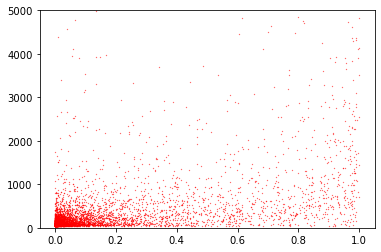

In [22]:

plt.plot(final_df["pred"], final_df["volume"], "ro", markersize="0.25")
plt.ylim(0, 5000)